In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import camb
import healpy as hp
from astropy.io import fits

from IPython.display import display, Math
import matplotlib.pyplot as plt
#from matplotlib_inline.backend_inline import set_matplotlib_formats
from astropy.visualization import quantity_support
import corner
from getdist import plots, MCSamples, loadMCSamples

quantity_support()
#set_matplotlib_formats('svg')
from matplotlib import cm
from cycler import cycler
colorblind = ["#4477AA", "#66CCEE", "#228833", "#CCBB44", "#EE6677", "#AA3377", "#BBBBBB"]
plt.rc('legend', frameon = False)
plt.rc('figure', figsize = (7, 7/1.25))
plt.rc('font', size = 14)

In [2]:
#isotropic noise first
l_max = 1200
nside = 512

#noise:
noise = fits.open('isotropic_noise_2rms_70_nside_512.fits')
noise_data = noise[1].data
noise_temp = noise_data['TEMPERATURE'].flatten()
noise_q    = noise_data['Q_POLARISATION'].flatten()
noise_u    = noise_data['U_POLARISATION'].flatten()

sigma_T_iso = np.sqrt(np.mean(noise_temp**2)) #50 muK/pixel
sigma_P_iso = np.sqrt(np.mean(noise_q**2))

N_l_T_iso = sigma_T_iso**2 * 4.*np.pi/(12.*nside**2)
N_l_P_iso = sigma_P_iso**2 * 4.*np.pi/(12.*nside**2)

#beam and pixel window:
beam = fits.open('Bl_TEB_npipe6v19_70GHzx70GHz.fits')[1]
pixel_window_T, pixel_window_P = np.array(hp.sphtfunc.pixwin(nside = nside, pol = True, lmax = l_max))

func_tt_iso = (beam.data['T'][:l_max+1] * pixel_window_T)**2
func_ee_iso = (beam.data['E'][:l_max+1] * pixel_window_P)**2
func_bb_iso = (beam.data['B'][:l_max+1] * pixel_window_P)**2
func_te_iso = pixel_window_T * pixel_window_P * beam.data['T'][:l_max+1] * beam.data['E'][:l_max+1]

#get C_ell^th:
cp = camb.set_params(tau=0.0544, ns=0.9649, H0=67.36, ombh2=0.02237, omch2=0.12, As=2.1e-9, lmax=l_max)
camb_results = camb.get_results(cp)
Cls_camb = camb_results.get_cmb_power_spectra(lmax=l_max, raw_cl=True, CMB_unit='muK')['lensed_scalar']
camb_tt_iso = Cls_camb[:l_max+1, 0] * func_tt_iso
camb_ee_iso = Cls_camb[:l_max+1, 1] * func_ee_iso
camb_bb_iso = Cls_camb[:l_max+1, 2] * func_bb_iso
camb_te_iso = Cls_camb[:l_max+1, 3] * func_te_iso

#get C_ell^sky:
cmbsim  = fits.open('isotropic_noise_with_cmb_nside_512.fits')
cmbsim  = cmbsim[1].data
tempmap = cmbsim['TEMPERATURE'].flatten()
qmap    = cmbsim['Q_POLARISATION'].flatten()
umap    = cmbsim['U_POLARISATION'].flatten()
C_ell_sky = hp.sphtfunc.anafast([tempmap, qmap, umap], lmax = l_max)#[:4]

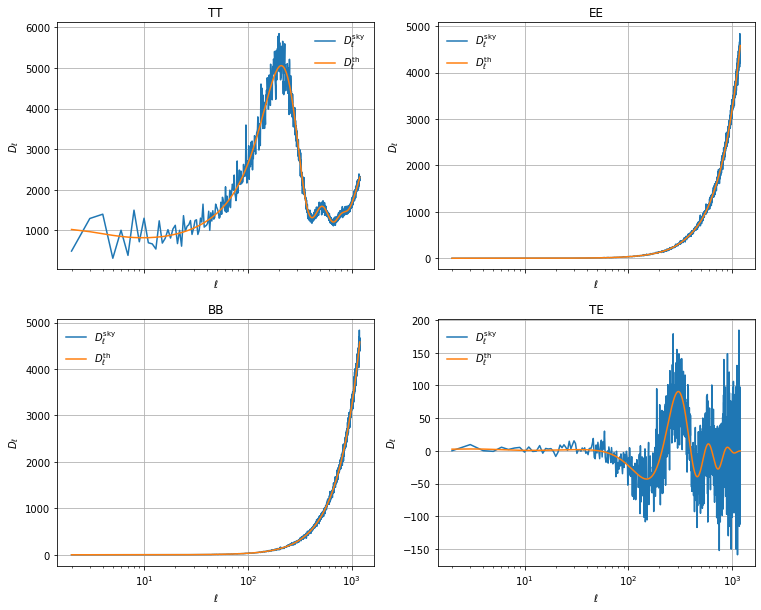

In [3]:
#plot
ells = np.arange(l_max+1)
ell_factor = ells*(ells+1)/(2*np.pi)
fig, axes = plt.subplots(figsize = (10*1.25, 10), nrows = 2, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].plot(ells[2:], (C_ell_sky[0]*ell_factor)[2:], label = r"$D_\ell^{\rm sky}$")
axs[0].plot(ells[2:], ((camb_tt_iso + N_l_T_iso)*ell_factor)[2:], label = r"$D_\ell^{\rm th}$")
axs[0].set_xscale("log")
axs[0].set_title("TT")

axs[1].plot(ells[2:], (C_ell_sky[1]*ell_factor)[2:], label = r"$D_\ell^{\rm sky}$")
axs[1].plot(ells[2:], ((camb_ee_iso + N_l_P_iso)*ell_factor)[2:], label = r"$D_\ell^{\rm th}$")
axs[1].set_xscale("log")
axs[1].set_title("EE")

axs[2].plot(ells[2:], (C_ell_sky[2]*ell_factor)[2:], label = r"$D_\ell^{\rm sky}$")
axs[2].plot(ells[2:], ((camb_bb_iso + N_l_P_iso)*ell_factor)[2:], label = r"$D_\ell^{\rm th}$")
axs[2].set_xscale("log")
axs[2].set_title("BB")

axs[3].plot(ells[2:], (C_ell_sky[3]*ell_factor)[2:], label = r"$D_\ell^{\rm sky}$")
axs[3].plot(ells[2:], (camb_te_iso*ell_factor)[2:], label = r"$D_\ell^{\rm th}$")
axs[3].set_title("TE")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$D_\ell$")
plt.show()

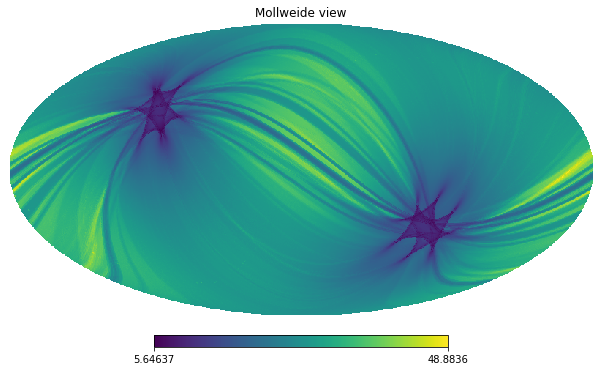

In [5]:
#C_ell_sky for anisotropic noise with galactic mask:
l_max = 1300
cl_sky_pspice = np.asarray(pd.read_csv("../../PolSpice/PolSpice_v03-07-05/cl_hp_apodize.dat", skiprows = [0], 
                           delim_whitespace=True, 
                           names = ["TT", "EE", "BB", "TE", "TB", "EB", "ET", "BT", "BE"]).iloc[:, 0:4])
cl_sky_tt = cl_sky_pspice[:l_max+1, 0]
cl_sky_ee = cl_sky_pspice[:l_max+1, 1]
cl_sky_bb = cl_sky_pspice[:l_max+1, 2]
cl_sky_te = cl_sky_pspice[:l_max+1, 3]

#C_ell_th for higher l_max
beam = fits.open('Bl_TEB_npipe6v19_70GHzx70GHz.fits')[1]
pixel_window_T, pixel_window_P = np.array(hp.sphtfunc.pixwin(nside = nside, pol = True, lmax = l_max))

func_tt_ani = (beam.data['T'][:l_max+1] * pixel_window_T)**2
func_ee_ani = (beam.data['E'][:l_max+1] * pixel_window_P)**2
func_bb_ani = (beam.data['B'][:l_max+1] * pixel_window_P)**2
func_te_ani = pixel_window_T * pixel_window_P * beam.data['T'][:l_max+1] * beam.data['E'][:l_max+1]

cp = camb.set_params(tau=0.0544, ns=0.9649, H0=67.36, ombh2=0.02237, omch2=0.12, As=2.1e-9, lmax=l_max)
camb_results = camb.get_results(cp)
Cls_camb = camb_results.get_cmb_power_spectra(lmax=l_max, raw_cl=True, CMB_unit='muK')['lensed_scalar']
camb_tt_ani = Cls_camb[:l_max+1, 0] * func_tt_ani
camb_ee_ani = Cls_camb[:l_max+1, 1] * func_ee_ani
camb_bb_ani = Cls_camb[:l_max+1, 2] * func_bb_ani
camb_te_ani = Cls_camb[:l_max+1, 3] * func_te_ani

#anisotropic N_l:
noise = fits.open('/mn/stornext/d16/cmbco/bp/johanres/commander_camb/camb_data/tod_070_rms_c0001_k000797_nside512.fits')
noise_data = noise[1].data
noise_temp = noise_data['TEMPERATURE'].flatten()
noise_q    = noise_data['Q_POLARISATION'].flatten()
noise_u    = noise_data['U_POLARISATION'].flatten()
hp.mollview(noise_temp)

sigma_T_ani = np.sqrt(np.mean(noise_temp**2))
sigma_P_ani = np.sqrt(np.mean(noise_q**2))

N_l_T_ani = sigma_T_ani**2 * 4.*np.pi/(12.*nside**2)
N_l_P_ani = sigma_P_ani**2 * 4.*np.pi/(12.*nside**2)

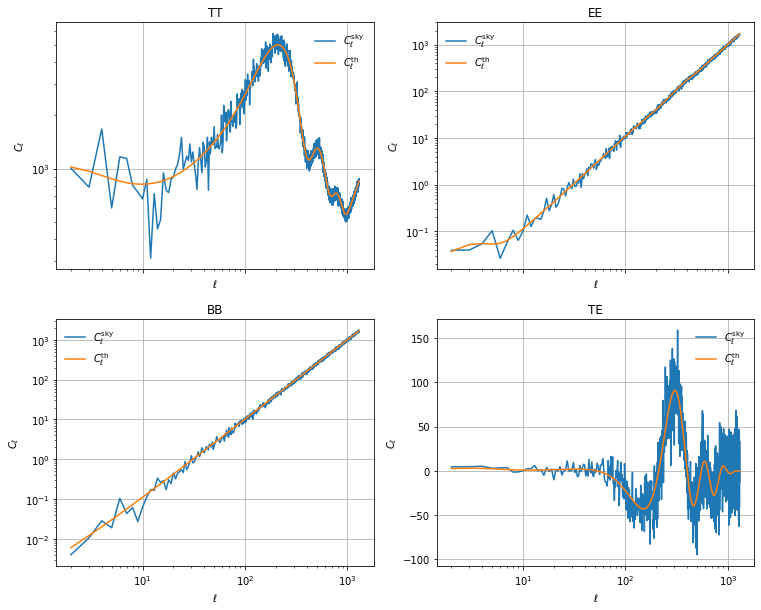

In [6]:
#same plot as before
ells = np.arange(l_max+1)
ell_factor = ells*(ells+1)/(2*np.pi)
fig, axes = plt.subplots(figsize = (10*1.25, 10), nrows = 2, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].loglog(ells[2:], (cl_sky_tt*ell_factor)[2:], label = r"$C_\ell^{\rm sky}$")
axs[0].plot(ells[2:], ((camb_tt_ani + N_l_T_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[0].set_title("TT")

axs[1].loglog(ells[2:], (cl_sky_ee*ell_factor)[2:], label = r"$C_\ell^{\rm sky}$")
axs[1].plot(ells[2:], ((camb_ee_ani + N_l_P_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[1].set_title("EE")

axs[2].loglog(ells[2:], (cl_sky_bb*ell_factor)[2:], label = r"$C_\ell^{\rm sky}$")
axs[2].plot(ells[2:], ((camb_bb_ani + N_l_P_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[2].set_title("BB")

axs[3].plot(ells[2:], (cl_sky_te*ell_factor)[2:], label = r"$C_\ell^{\rm sky}$")
axs[3].plot(ells[2:], (camb_te_ani*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[3].set_title("TE")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$C_\ell$")
plt.show()

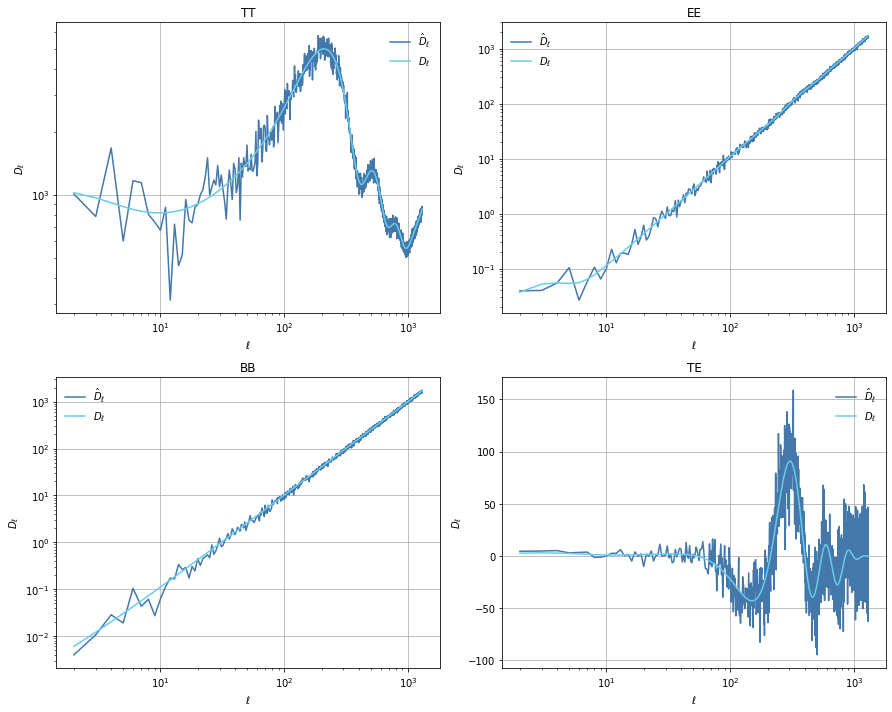

In [9]:
#add a bunch of parameter estimates
cols = np.array(["ombh2", "omch2", "H0", "tau", "A", "ns"])
l_max = 1300

#cobaya (Wishart likelihood)
chain = pd.read_csv("chains/mask_more_samples.1.txt", header = 0, delim_whitespace = True)
samples = chain[cols].iloc[10:]
params = np.mean(samples, axis = 0)

cp_cobaya = camb.set_params(tau=params["tau"], ns=params["ns"], H0=params["H0"], ombh2=params["ombh2"], omch2=params["omch2"], As=params["A"]*1e-9, lmax=l_max)
cobaya_results = camb.get_results(cp_cobaya)
Cls_cobaya = cobaya_results.get_cmb_power_spectra(lmax=l_max, raw_cl=True, CMB_unit='muK')['lensed_scalar']
cobaya_tt = Cls_cobaya[:l_max+1, 0] * func_tt_ani
cobaya_ee = Cls_cobaya[:l_max+1, 1] * func_ee_ani
cobaya_bb = Cls_cobaya[:l_max+1, 2] * func_bb_ani
cobaya_te = Cls_cobaya[:l_max+1, 3] * func_te_ani

#cobaya (binned likelihood)
chain_gal = pd.read_csv("chains/mask_gal_binW.1.txt", header = 0, delim_whitespace = True)
samples_gal = chain_gal[cols].iloc[10:]
params_gal = np.mean(samples_gal, axis = 0)

cp_gal = camb.set_params(tau=params_gal["tau"], ns=params_gal["ns"], H0=params_gal["H0"], 
                         ombh2=params_gal["ombh2"], omch2=params_gal["omch2"], As=params_gal["A"]*1e-9, lmax = l_max)
gal_results = camb.get_results(cp_gal)
Cls_gal = gal_results.get_cmb_power_spectra(lmax = l_max, raw_cl = True, CMB_unit = 'muK')['lensed_scalar']
gal_tt = Cls_gal[:l_max+1, 0] * func_tt_ani
gal_ee = Cls_gal[:l_max+1, 1] * func_ee_ani
gal_bb = Cls_gal[:l_max+1, 2] * func_bb_ani
gal_te = Cls_gal[:l_max+1, 3] * func_te_ani

#commander
chain_comm = np.loadtxt("/mn/stornext/d16/cmbco/bp/johanres/commander_camb/Commander/chains_camb_anisotropic_noise_nside512_realisticmask/cosmo_param_out.dat")
samples_comm = chain_comm[10:]
params_comm = np.mean(samples_comm, axis = 0)

cp_comm = camb.set_params(tau = params_comm[3], ns = params_comm[5], H0 = params_comm[2],
                          ombh2 = params_comm[0], omch2 = params_comm[1], As = params_comm[4]*1e-9, lmax = l_max)
comm_results = camb.get_results(cp_comm)
Cls_comm = comm_results.get_cmb_power_spectra(lmax = l_max, raw_cl = True, CMB_unit = 'muK')['lensed_scalar']
comm_tt = Cls_comm[:l_max+1, 0] * func_tt_ani
comm_ee = Cls_comm[:l_max+1, 1] * func_ee_ani
comm_bb = Cls_comm[:l_max+1, 2] * func_bb_ani
comm_te = Cls_comm[:l_max+1, 3] * func_te_ani

def plot_Dl(lmax):
    fig = plt.figure(layout = 'tight', figsize = (10*1.25, 10))
    axes = fig.subplots(nrows = 2, ncols = 2)
    custom_cycler = cycler("color", colorblind)
    axs = axes.flatten()
    for axi in axs:
        axi.set_prop_cycle(custom_cycler)
        
    axs[0].loglog(ells[2:lmax], (cl_sky_tt*ell_factor)[2:lmax], label = r"$\hat{D}_\ell$")
    #axs[0].plot(ells[2:lmax], ((cl_sky_tt/(gal_tt + N_l_T_ani)))[2:lmax], label = "scaled")
    axs[0].plot(ells[2:lmax], ((camb_tt_ani + N_l_T_ani)*ell_factor)[2:lmax], label = r"$D_\ell$")
    #axs[0].plot(ells[2:lmax], ((cobaya_tt + N_l_T_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm Wishart}$")
    #axs[0].plot(ells[2:lmax], ((gal_tt + N_l_T_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm binned}$")
    #axs[0].plot(ells[2:lmax], ((comm_tt + N_l_T_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\tt Commander}$")
    axs[0].set_title("TT")
    #axs[0].set_yscale("log")
    
    axs[1].loglog(ells[2:lmax], (cl_sky_ee*ell_factor)[2:lmax], label = r"$\hat{D}_\ell$")
    axs[1].plot(ells[2:lmax], ((camb_ee_ani + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell$")
    #axs[1].plot(ells[2:lmax], ((cobaya_ee + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm Wishart}$")
    #axs[1].plot(ells[2:lmax], ((gal_ee + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm binned}$")
    #axs[1].plot(ells[2:lmax], ((comm_ee + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\tt Commander}$")
    axs[1].set_title("EE")
    
    axs[2].loglog(ells[2:lmax], (cl_sky_bb*ell_factor)[2:lmax], label = r"$\hat{D}_\ell$")
    axs[2].plot(ells[2:lmax], ((camb_bb_ani + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell$")
    #axs[2].plot(ells[2:lmax], ((cobaya_bb + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm Wishart}$")
    #axs[2].plot(ells[2:lmax], ((gal_bb + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\rm binned}$")
    #axs[2].plot(ells[2:lmax], ((comm_bb + N_l_P_ani)*ell_factor)[2:lmax], label = r"$D_\ell^{\tt Commander}$")
    axs[2].set_title("BB")
    
    axs[3].plot(ells[2:lmax], (cl_sky_te*ell_factor)[2:lmax], label = r"$\hat{D}_\ell$")
    axs[3].plot(ells[2:lmax], (camb_te_ani*ell_factor)[2:lmax], label = r"$D_\ell$")
    #axs[3].plot(ells[2:lmax], (cobaya_te*ell_factor)[2:lmax], label = r"$D_\ell^{\rm Wishart}$")
    #axs[3].plot(ells[2:lmax], (gal_te*ell_factor)[2:lmax], label = r"$D_\ell^{\rm binned}$")
    #axs[3].plot(ells[2:lmax], (comm_te*ell_factor)[2:lmax], label = r"$D_\ell^{\tt Commander}$")
    axs[3].set_title("TE")
    axs[3].set_xscale("log")
    for axi in axs:
        axi.legend()
        axi.grid()
        axi.set_xlabel(r"$\ell$")
        axi.set_ylabel(r"$D_\ell$")
    plt.savefig('../../thesis_figures/Sample_Dl.pdf')
    plt.show()
    
plot_Dl(1301)

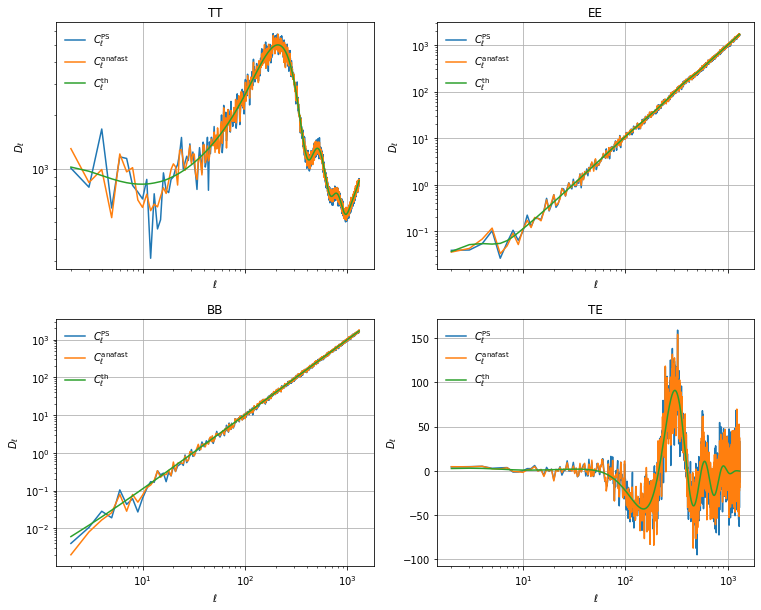

In [8]:
cmb_anafast = fits.open('/mn/stornext/d16/cmbco/bp/johanres/commander_camb/camb_data/anisotropic_noise_with_cmb_no_dipole_no_monopole_nside512.fits')
cmb_anafast = cmb_anafast[1].data
tempmap = cmb_anafast['TEMPERATURE'].flatten()
qmap    = cmb_anafast['Q_POLARISATION'].flatten()
umap    = cmb_anafast['U_POLARISATION'].flatten()
Cls_anafast = hp.sphtfunc.anafast([tempmap, qmap, umap], lmax = 1300)

ells = np.arange(1301)
ell_factor = ells*(ells+1)/(2*np.pi)

fig, axes = plt.subplots(figsize = (10*1.25, 10), nrows = 2, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].loglog(ells[2:], (cl_sky_tt*ell_factor)[2:], label = r"$C_\ell^{\rm PS}$")
axs[0].loglog(ells[2:], (Cls_anafast[0]*ell_factor)[2:], label = r"$C_\ell^{\rm anafast}$")
axs[0].plot(ells[2:], ((camb_tt_ani + N_l_T_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[0].set_title("TT")

axs[1].loglog(ells[2:], (cl_sky_ee*ell_factor)[2:], label = r"$C_\ell^{\rm PS}$")
axs[1].loglog(ells[2:], (Cls_anafast[1]*ell_factor)[2:], label = r"$C_\ell^{\rm anafast}$")
axs[1].plot(ells[2:], ((camb_ee_ani + N_l_P_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[1].set_title("EE")

axs[2].loglog(ells[2:], (cl_sky_bb*ell_factor)[2:], label = r"$C_\ell^{\rm PS}$")
axs[2].loglog(ells[2:], (Cls_anafast[2]*ell_factor)[2:], label = r"$C_\ell^{\rm anafast}$")
axs[2].plot(ells[2:], ((camb_bb_ani + N_l_P_ani)*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[2].set_title("BB")

axs[3].plot(ells[2:], (cl_sky_te*ell_factor)[2:], label = r"$C_\ell^{\rm PS}$")
axs[3].plot(ells[2:], (Cls_anafast[3]*ell_factor)[2:], label = r"$C_\ell^{\rm anafast}$")
axs[3].plot(ells[2:], (camb_te_ani*ell_factor)[2:], label = r"$C_\ell^{\rm th}$")
axs[3].set_title("TE")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$D_\ell$")
plt.show()

Nside = 16


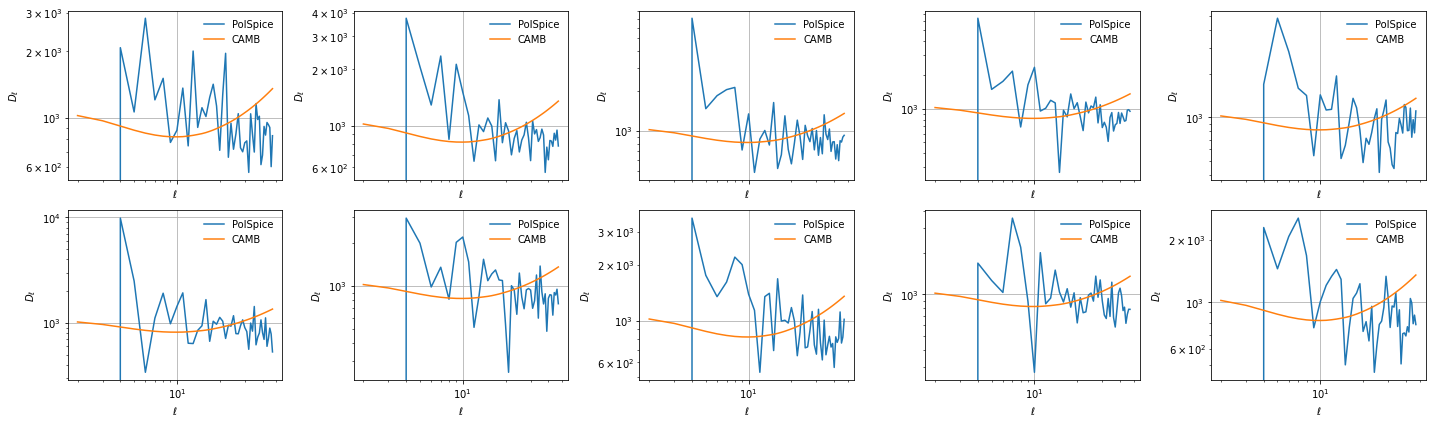

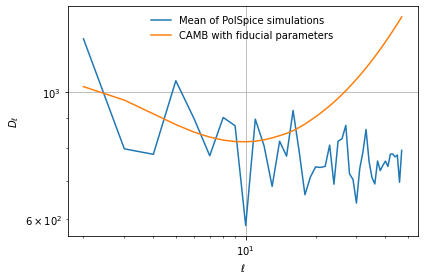

In [9]:
nside = 16
l_max = 3*nside - 1
low_ell = np.arange(l_max+1)
ell_factor = (low_ell*(low_ell+1)/(2*np.pi))[2:]

print(f"Nside = {nside}")

fig, axes = plt.subplots(figsize = (20, 6), nrows = 2, ncols = 5, sharex = True)
axs = axes.flatten()
for i in range(10):
    cls_sims = np.asarray(pd.read_csv(f"../../PolSpice/PolSpice_v03-07-05/cl_sims/cl_sims_{i}_nside{nside}.dat", index_col = 0, skiprows = [0], 
                                      delim_whitespace=True,
                                      names = ["TT", "EE", "BB", "TE", "TB", "EB", "ET", "BT", "BE"]).iloc[:, :6])
    cls_sims = cls_sims.flatten('F')
    axs[i].loglog(low_ell[2:], cls_sims[:46]*ell_factor, label = "PolSpice")
    axs[i].plot(low_ell[2:], ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlabel(r"$\ell$")
    axs[i].set_ylabel(r"$D_\ell$")
plt.tight_layout()
plt.show()

mu_ell = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/mu_ell_{nside}.txt")
plt.figure()
plt.loglog(low_ell[2:], mu_ell[:46]*ell_factor, label = "Mean of PolSpice simulations")
plt.plot(low_ell[2:], ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB with fiducial parameters")
plt.legend()
plt.grid()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$")
plt.tight_layout()
plt.show()

Nside = 32


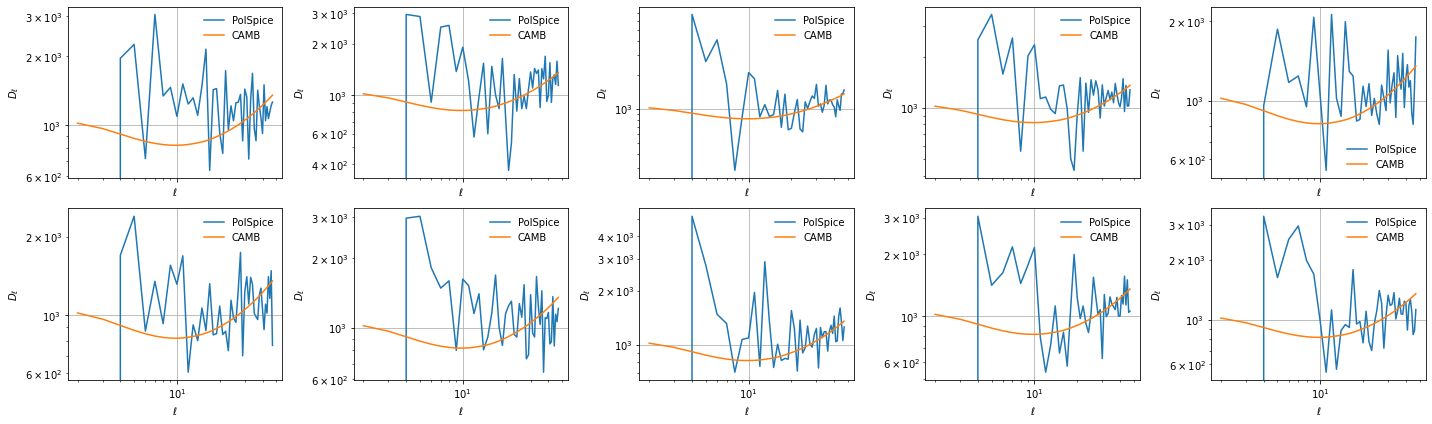

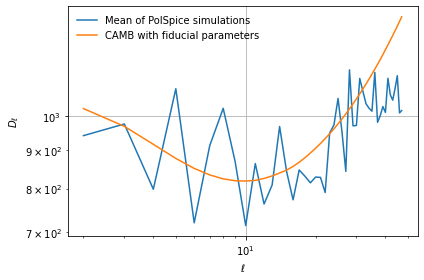

In [10]:
nside = 32
l_max = 3*nside - 1

print(f"Nside = {nside}")

fig, axes = plt.subplots(figsize = (20, 6), nrows = 2, ncols = 5, sharex = True)
axs = axes.flatten()
for i in range(10):
    cls_sims = np.asarray(pd.read_csv(f"../../PolSpice/PolSpice_v03-07-05/cl_sims/cl_sims_{i}_nside{nside}.dat", index_col = 0, skiprows = [0], 
                                      delim_whitespace=True,
                                      names = ["TT", "EE", "BB", "TE", "TB", "EB", "ET", "BT", "BE"]).iloc[:, :6])
    cls_sims = cls_sims.flatten('F')
    axs[i].loglog(low_ell[2:], cls_sims[:46]*ell_factor, label = "PolSpice")
    axs[i].plot(low_ell[2:], ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlabel(r"$\ell$")
    axs[i].set_ylabel(r"$D_\ell$")
plt.tight_layout()
plt.show()

mu_ell = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/mu_ell_{nside}.txt")
plt.figure()
plt.loglog(low_ell[2:], mu_ell[:46]*ell_factor, label = "Mean of PolSpice simulations")
plt.plot(low_ell[2:], ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB with fiducial parameters")
plt.legend()
plt.grid()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$")
plt.tight_layout()
plt.show()

Nside = 64


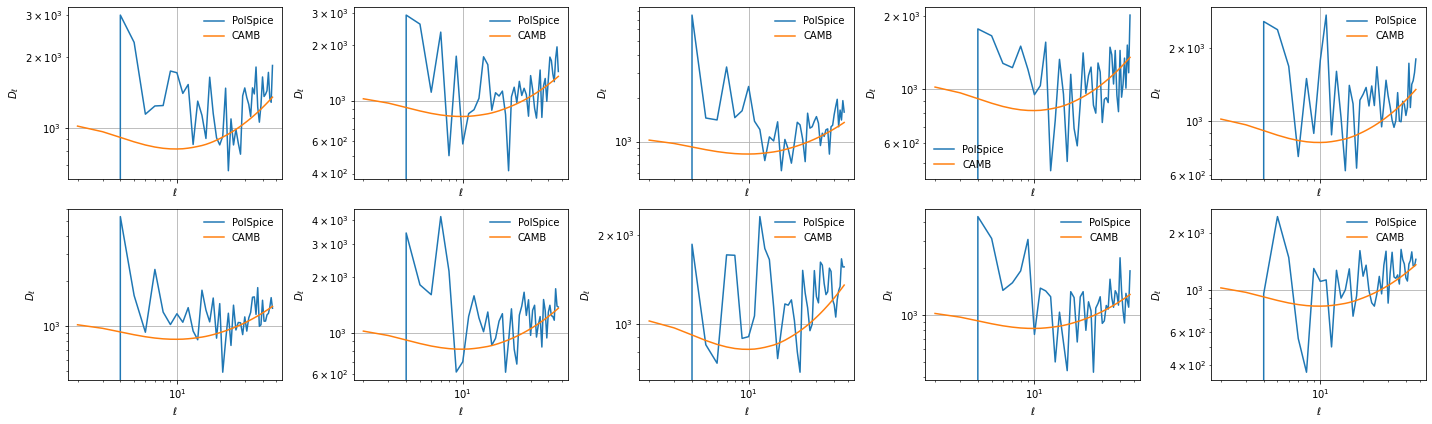

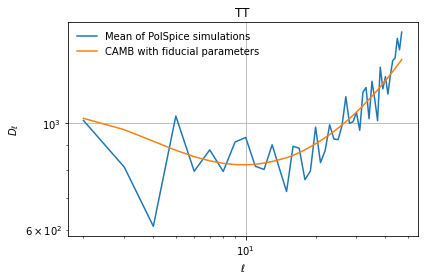

In [10]:
nside = 64
l_max = 3*nside - 1
low_ell = np.arange(l_max+1)[2:48]
ell_factor = (low_ell*(low_ell+1)/(2*np.pi))

print(f"Nside = {nside}")

fig, axes = plt.subplots(figsize = (20, 6), nrows = 2, ncols = 5, sharex = True)
axs = axes.flatten()
for i in range(10):
    cls_sims = np.asarray(pd.read_csv(f"../../PolSpice/PolSpice_v03-07-05/cl_sims/cl_sims_{i}_nside{nside}.dat", index_col = 0, skiprows = [0], 
                                      delim_whitespace=True,
                                      names = ["TT", "EE", "BB", "TE", "TB", "EB", "ET", "BT", "BE"]).iloc[:, :6])
    cls_sims = cls_sims.flatten('F')
    axs[i].loglog(low_ell, cls_sims[:46]*ell_factor, label = "PolSpice")
    axs[i].plot(low_ell, ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB")
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlabel(r"$\ell$")
    axs[i].set_ylabel(r"$D_\ell$")
plt.tight_layout()
plt.show()

mu_ell = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/mu_ell_{nside}.txt")
mu_ell = np.split(mu_ell, 6)
plt.figure()
plt.loglog(low_ell, mu_ell[0][:46]*ell_factor, label = "Mean of PolSpice simulations")
plt.plot(low_ell, ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB with fiducial parameters")
plt.legend()
plt.grid()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$")
plt.title("TT")
plt.tight_layout()
plt.show()

EE ratio:  1.0356210471376395
BB ratio:  1.0417807430074455


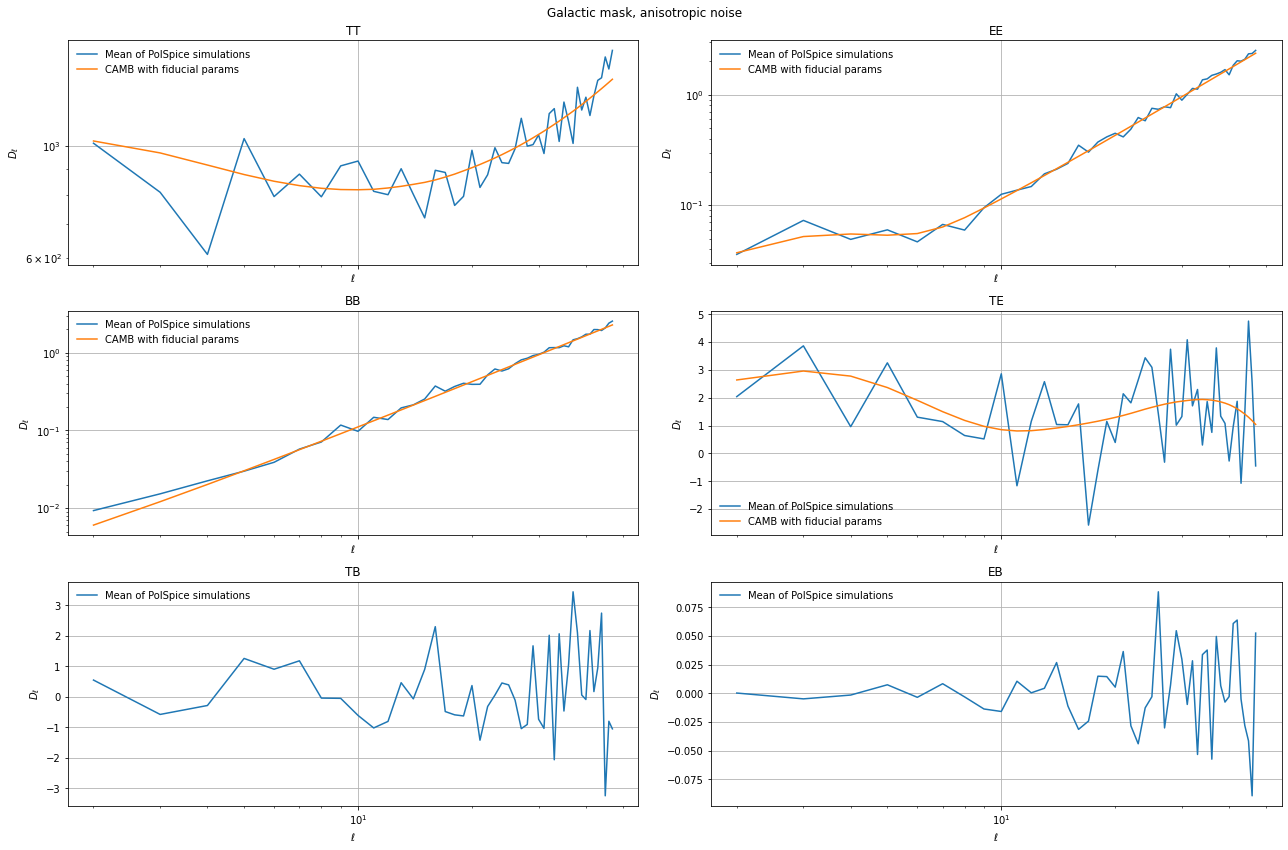

In [11]:
print("EE ratio: ", np.mean(mu_ell[1][:46])/np.mean((camb_ee_ani + N_l_P_ani)[2:48]))
print("BB ratio: ", np.mean(mu_ell[2][:46])/np.mean((camb_bb_ani + N_l_P_ani)[2:48]))

fig, axes = plt.subplots(figsize = (12*1.5, 12), nrows = 3, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].loglog(low_ell, mu_ell[0][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[0].plot(low_ell, ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[0].set_title("TT")

axs[1].loglog(low_ell, (mu_ell[1][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[1].plot(low_ell, ((camb_ee_ani + N_l_P_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[1].set_title("EE")

axs[2].loglog(low_ell, (mu_ell[2][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[2].plot(low_ell, ((camb_bb_ani + N_l_P_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[2].set_title("BB")

axs[3].plot(low_ell, (mu_ell[3][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[3].plot(low_ell, (camb_te_ani[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[3].set_title("TE")

axs[4].plot(low_ell, mu_ell[4][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[4].set_title("TB")

axs[5].plot(low_ell, mu_ell[5][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[5].set_title("EB")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$D_\ell$")
fig.suptitle("Galactic mask, anisotropic noise")
plt.tight_layout()
plt.show()

EE ratio:  1.0141786098553238
BB ratio:  1.015135896224111


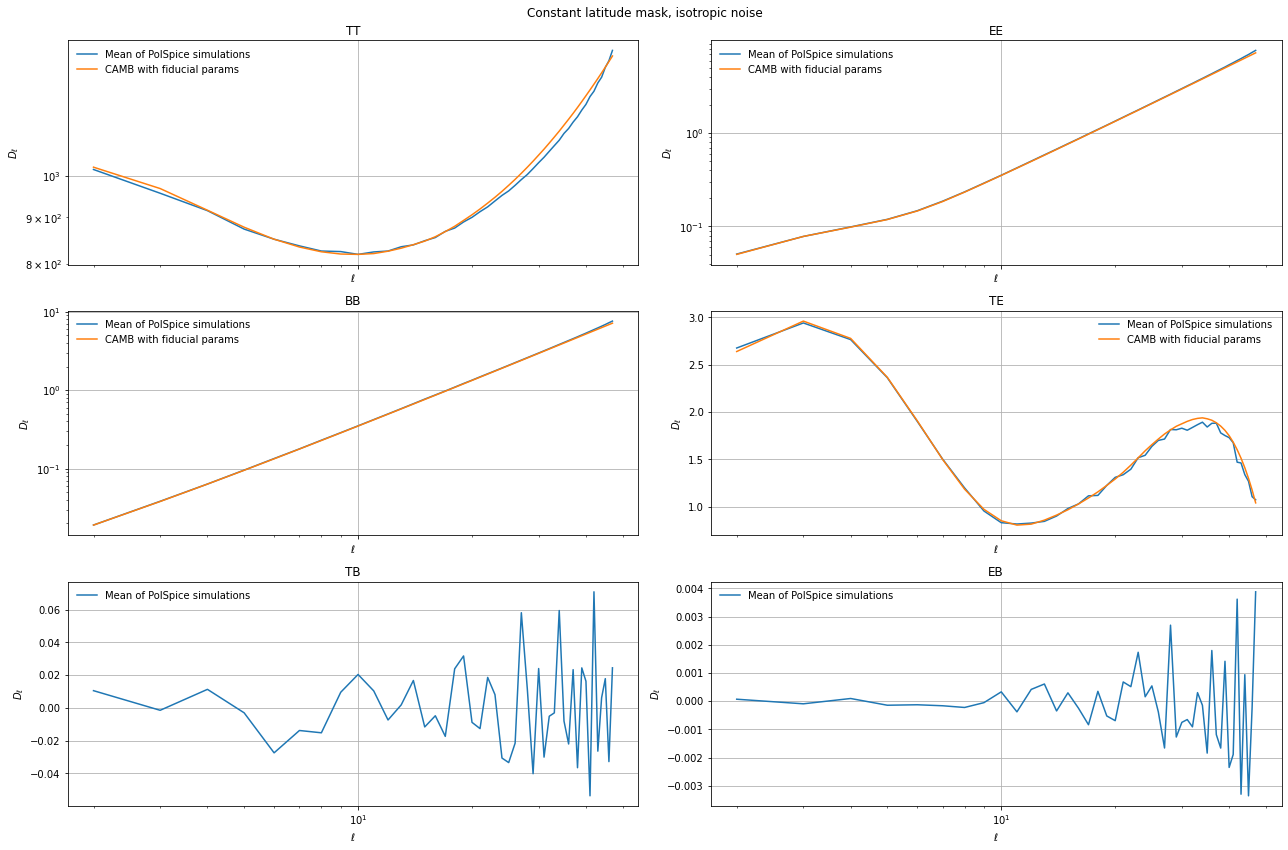

In [12]:
mu_ell_const = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/mu_ell_const.txt")
mu_ell_const = np.split(mu_ell_const, 6)

print("EE ratio: ", np.mean(mu_ell_const[1][:46])/np.mean((camb_ee_iso + N_l_P_iso)[2:48]))
print("BB ratio: ", np.mean(mu_ell_const[2][:46])/np.mean((camb_bb_iso + N_l_P_iso)[2:48]))

fig, axes = plt.subplots(figsize = (12*1.5, 12), nrows = 3, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].loglog(low_ell, mu_ell_const[0][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[0].plot(low_ell, ((camb_tt_iso + N_l_T_iso)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[0].set_title("TT")

axs[1].loglog(low_ell, (mu_ell_const[1][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[1].plot(low_ell, ((camb_ee_iso + N_l_P_iso)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[1].set_title("EE")

axs[2].loglog(low_ell, (mu_ell_const[2][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[2].plot(low_ell, ((camb_bb_iso + N_l_P_iso)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[2].set_title("BB")

axs[3].plot(low_ell, (mu_ell_const[3][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[3].plot(low_ell, (camb_te_iso[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[3].set_title("TE")

axs[4].plot(low_ell, mu_ell_const[4][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[4].set_title("TB")

axs[5].plot(low_ell, mu_ell_const[5][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[5].set_title("EB")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$D_\ell$")
fig.suptitle("Constant latitude mask, isotropic noise")
plt.tight_layout()
plt.show()

EE ratio:  1.0225089804772887
BB ratio:  1.0094071209186464


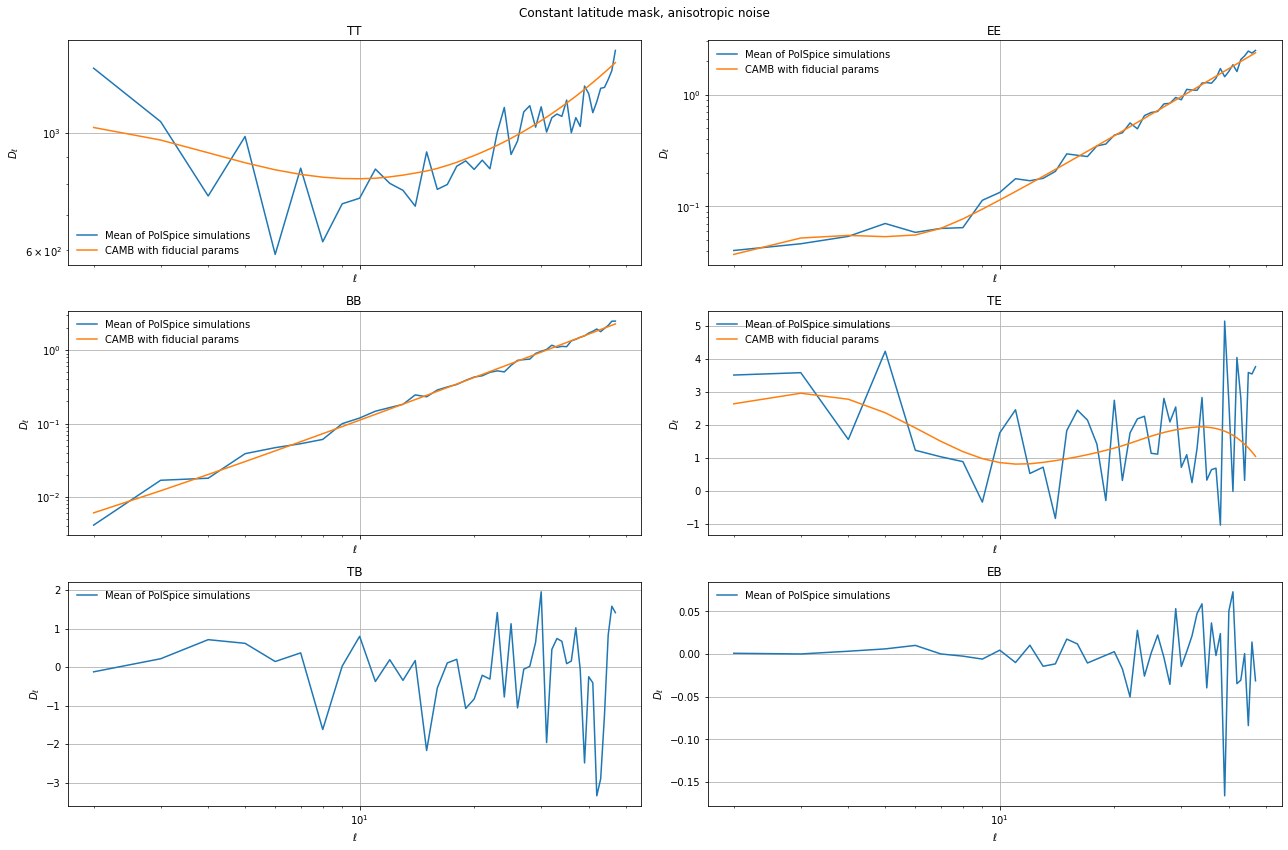

In [13]:
mu_ell_const_ani = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/mu_ell_const_ani.txt")
mu_ell_const_ani = np.split(mu_ell_const_ani, 6)

print("EE ratio: ", np.mean(mu_ell_const_ani[1][:46])/np.mean((camb_ee_ani + N_l_P_ani)[2:48]))
print("BB ratio: ", np.mean(mu_ell_const_ani[2][:46])/np.mean((camb_bb_ani + N_l_P_ani)[2:48]))

fig, axes = plt.subplots(figsize = (12*1.5, 12), nrows = 3, ncols = 2, sharex = True)
axs = axes.flatten()
axs[0].loglog(low_ell, mu_ell_const_ani[0][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[0].plot(low_ell, ((camb_tt_ani + N_l_T_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[0].set_title("TT")

axs[1].loglog(low_ell, (mu_ell_const_ani[1][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[1].plot(low_ell, ((camb_ee_ani + N_l_P_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[1].set_title("EE")

axs[2].loglog(low_ell, (mu_ell_const_ani[2][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[2].plot(low_ell, ((camb_bb_ani + N_l_P_ani)[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[2].set_title("BB")

axs[3].plot(low_ell, (mu_ell_const_ani[3][:46]*ell_factor), label = "Mean of PolSpice simulations")
axs[3].plot(low_ell, (camb_te_ani[2:48]*ell_factor), label = "CAMB with fiducial params")
axs[3].set_title("TE")

axs[4].plot(low_ell, mu_ell_const_ani[4][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[4].set_title("TB")

axs[5].plot(low_ell, mu_ell_const_ani[5][:46]*ell_factor, label = "Mean of PolSpice simulations")
axs[5].set_title("EB")

for axi in axs:
    axi.legend()
    axi.grid()
    axi.set_xlabel(r"$\ell$")
    axi.set_ylabel(r"$D_\ell$")
fig.suptitle("Constant latitude mask, anisotropic noise")
plt.tight_layout()
plt.show()

In [14]:
cp = camb.set_params(tau=0.0544, ns=0.9649, H0=67.36, ombh2=0.02237, omch2=0.12, As=2.1e-9, lmax=1300)
camb_results = camb.get_results(cp)
Cls_camb = camb_results.get_cmb_power_spectra(lmax=1300, raw_cl=True, CMB_unit='muK')['lensed_scalar']
Cls_camb = pd.DataFrame(Cls_camb, columns = ["tt", "ee", "bb", "te"])

beam = fits.open('Bl_TEB_npipe6v19_70GHzx70GHz.fits')[1]
pixel_window_T, pixel_window_P = np.array(hp.sphtfunc.pixwin(nside = 512, pol = True, lmax = 1300))

func_tt_ani = (beam.data['T'][:1301] * pixel_window_T)**2
func_ee_ani = (beam.data['E'][:1301] * pixel_window_P)**2
func_bb_ani = (beam.data['B'][:1301] * pixel_window_P)**2
func_te_ani = pixel_window_T * pixel_window_P * beam.data['T'][:1301] * beam.data['E'][:1301]

Cls_camb['tt'] = Cls_camb['tt'][:1301] * func_tt_ani + N_l_T_ani
Cls_camb['ee'] = Cls_camb['ee'][:1301] * func_ee_ani + N_l_P_ani
Cls_camb['bb'] = Cls_camb['bb'][:1301] * func_bb_ani + N_l_P_ani
Cls_camb['te'] = Cls_camb['te'][:1301] * func_te_ani

Cls_camb

,tt,ee,bb,te
0,0.003154,0.006344,0.006344,0.000000e+00
1,0.003154,0.006344,0.006344,0.000000e+00
2,1070.778892,0.038937,0.006346,2.762971e+00
3,507.032397,0.027296,0.006346,1.549671e+00
4,287.878654,0.017275,0.006346,8.724344e-01
...,...,...,...,...
1296,0.003177,0.006345,0.006344,-9.659416e-07
1297,0.003177,0.006345,0.006344,-9.803644e-07
1298,0.003177,0.006345,0.006344,-9.943970e-07
1299,0.003176,0.006345,0.006344,-1.008038e-06


In [15]:
Cls_camb_tt = np.asarray(Cls_camb['tt'][:1301] * func_tt_ani + N_l_T_ani)
Cls_camb_ee = np.asarray(Cls_camb['ee'][:1301] * func_ee_ani + N_l_P_ani)
Cls_camb_bb = np.asarray(Cls_camb['bb'][:1301] * func_bb_ani + N_l_P_ani)
Cls_camb_te = np.asarray(Cls_camb['te'][:1301] * func_te_ani)
print(Cls_camb_tt.shape)

Cls_map_theo = np.concatenate((np.stack((Cls_camb_tt, Cls_camb_ee, Cls_camb_bb, Cls_camb_te), axis = 1), np.zeros((1301, 2))), axis = 1)
Cls_theo_lowl = Cls_map_theo[2:30].flatten('F')

(1301,)


In [16]:
M_ell_all = np.loadtxt(f"../../PolSpice/PolSpice_v03-07-05/M_ell_gal.txt")

#get each sub-matrix
M_ell_all = M_ell_all.reshape(6, 46, -1, 46).swapaxes(1, 2).reshape(-1, 46, 46)

#crop to ell<30
M_ell = np.zeros((36, 28, 28))
M_ell[:, :, :] = M_ell_all[:, :28, :28]

#set off-diagonal elements to 0
diag = np.arange(6)*7
for i in range(36):
    if i in diag:
        M_ell[i, :, :] = M_ell[i, :, :]
    else:
        M_ell[i, :, :] = np.zeros((28, 28))
        
#shape back into normal
M_ell = M_ell.reshape(6, -1, 28, 28).swapaxes(1, 2).reshape(168, 168)
M_ell.shape

(168, 168)

In [17]:
Cls = np.asarray(pd.read_csv("../../PolSpice/PolSpice_v03-07-05/cl_hp_apodize.dat", skiprows = [0], 
                             delim_whitespace=True, 
                             names = ["TT", "EE", "BB", "TE", "TB", "EB", "ET", "BT", "BE"]).iloc[:, 0:6])
Cls_map_lowl = Cls[2:30].flatten('F')
C_ell = Cls_map_lowl - Cls_theo_lowl

Cls_map_highl = np.zeros((1301, 3, 3))
Cls_theo_highl = np.zeros((1301, 3, 3))
for ell in range(1301):
    Cls_map_highl[ell] = np.array([[Cls[ell, 0], Cls[ell, 3], Cls[ell, 4]],
                                   [Cls[ell, 3], Cls[ell, 1], Cls[ell, 5]],
                                   [Cls[ell, 4], Cls[ell, 5], Cls[ell, 2]]])
    Cls_theo_highl[ell] = np.array([[Cls_camb_tt[ell], Cls_camb_te[ell], 0.              ],
                                    [Cls_camb_te[ell],   Cls_camb_ee[ell], 0.              ],
                                    [0.,                    0.,            Cls_camb_bb[ell]]])
"""
f_sky = 0.85
for ell in range(30, 1301):
    const = -(2*ell + 1) * f_sky**2
    logp += const * np.dot(Cls_map_highl[ell] - Cls_theo_highl[ell], 
                           np.linalg.inv(Cls_theo_highl[ell]))**2
"""

print(Cls_map_highl[30] - Cls_theo_highl[30])
print(np.linalg.inv(Cls_theo_highl[30]))

[[ 0.2904038  -0.00875277 -0.03292212]
 [-0.00875277 -0.00727565 -0.00099153]
 [-0.03292212 -0.00099153 -0.00434566]]
[[ 0.14114666 -0.13915826  0.        ]
 [-0.13915826 78.19441064  0.        ]
 [ 0.          0.         78.9374535 ]]
